# Предсказание цены на жильё в AirBnb

- Построение модели линейной регрессии
- Настройка гиперпараметров на кросс-валидации
- Интерпретация коэффициентов

Датасет: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression, Lasso, LassoCV

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics

from scipy.spatial.distance import euclidean

plt.rcParams['figure.figsize'] = 16, 8

In [298]:
df = pd.read_csv('AB_NYC_2019.csv')

- **Удаляем переменные `id`, `name`, `host_id`, `host_name`, `last_review`:**

In [299]:
df = df.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1)

In [300]:
print(f'Размер выборки: {df.shape}')
df.head()

Размер выборки: (48895, 11)


,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


In [302]:
df.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

- **Попробуем удалить `reviews_per_month`, оно вроде как немного коррелирует с `number_of_reviews`:**

In [303]:
df[['number_of_reviews', 'reviews_per_month']].corr()

,number_of_reviews,reviews_per_month
number_of_reviews,1.000000,0.549868
reviews_per_month,0.549868,1.000000


In [304]:
df = df.drop('reviews_per_month', axis=1)

### Базовые статистики, визуализации (распределения, корреляции, pair plots)

In [305]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,327.000000,365.000000


In [306]:
df.describe(include=['object'])

,neighbourhood_group,neighbourhood,room_type
count,48895,48895,48895
unique,5,221,3
top,Manhattan,Williamsburg,Entire home/apt
freq,21661,3920,25409


In [182]:
df.price[df.price==0].count()

11

- **Уберем строки с нулевым значением цены, их всего 11**

In [307]:
df = df[~(df.price==0)]
df.price.describe()

count    48884.000000
mean       152.755053
std        240.170260
min         10.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

### Заменим координаты на евклидово расстояние от квартиры до цента Нью Йорка

- **Явно можно проще сделать, но пока так:**

In [308]:
new_york_center = [40.728333, -73.994167]
latitude, longitude = df['latitude'], df['longitude']
center_distance = [euclidean(x, new_york_center) for x in zip(latitude, longitude)]
df['center_distance'] = center_distance

- **Координаты больше не нужны:**

In [309]:
df = df.drop(['latitude', 'longitude'], axis=1)

- **Распределение целевой переменной**

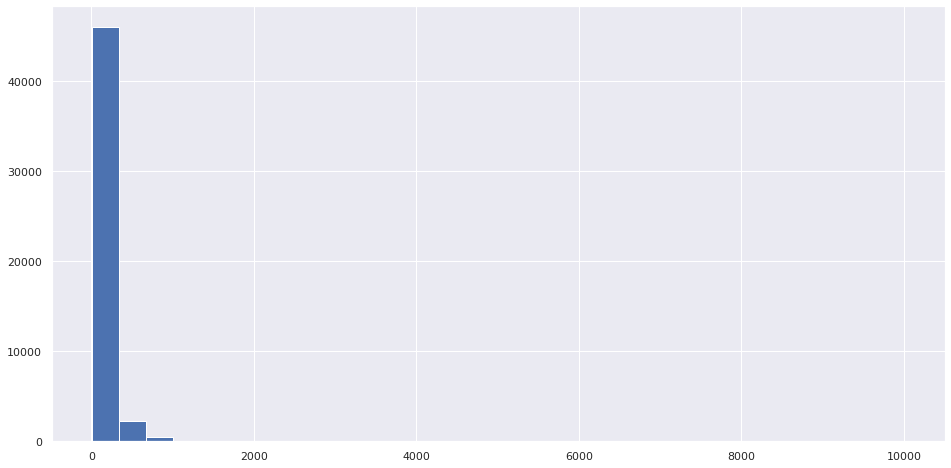

In [310]:
df.price.hist(bins=30);

- **Прологарифмируем**:

In [311]:
df['price'] = np.log(df['price'])

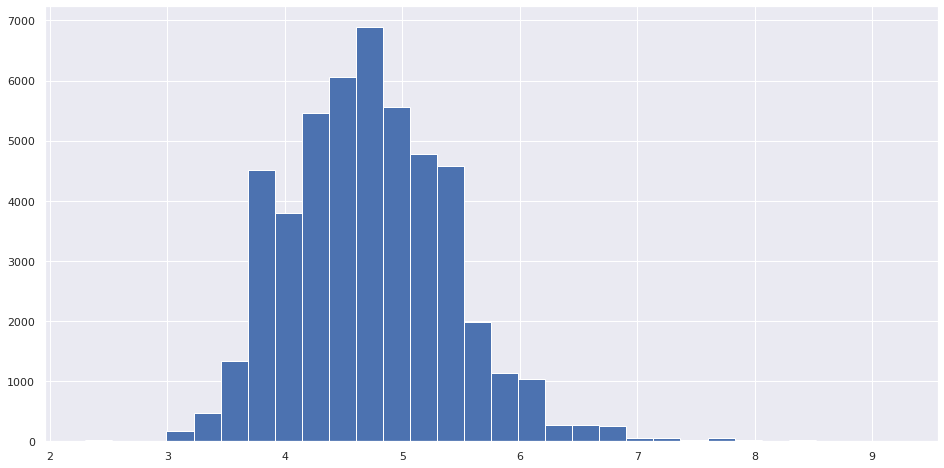

In [312]:
df.price.hist(bins=30);

### Распределение остальных переменных

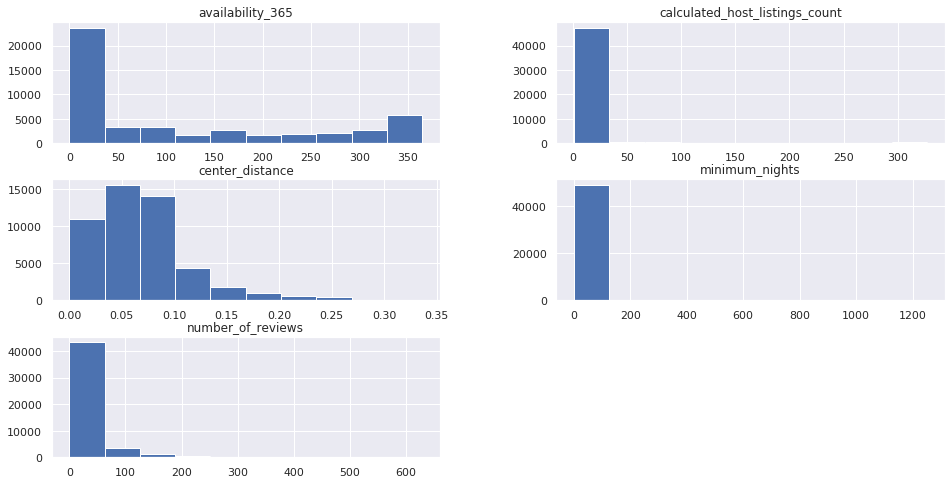

In [272]:
df.drop('price', axis=1).hist();

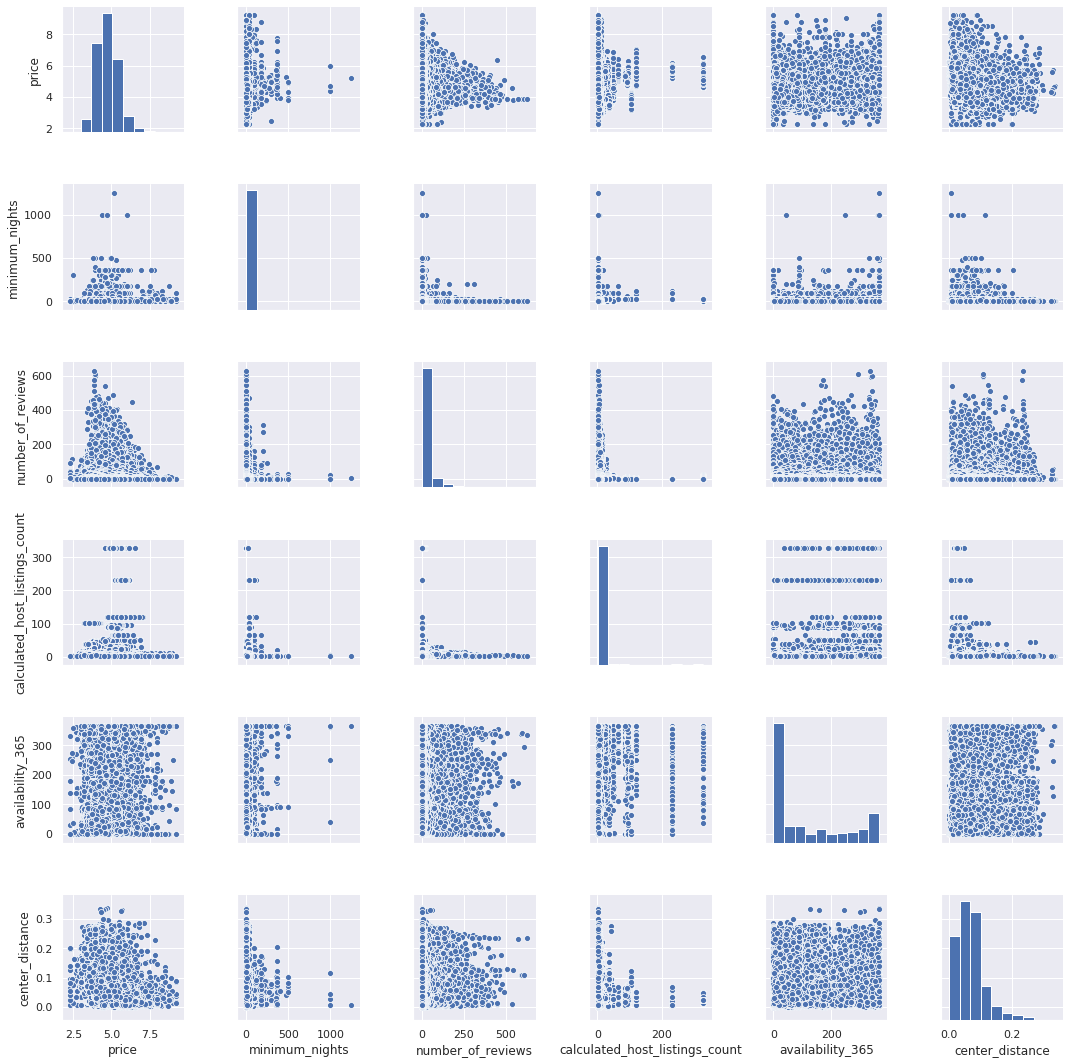

In [190]:
sns.pairplot(df);

- **Neighbourhood group**

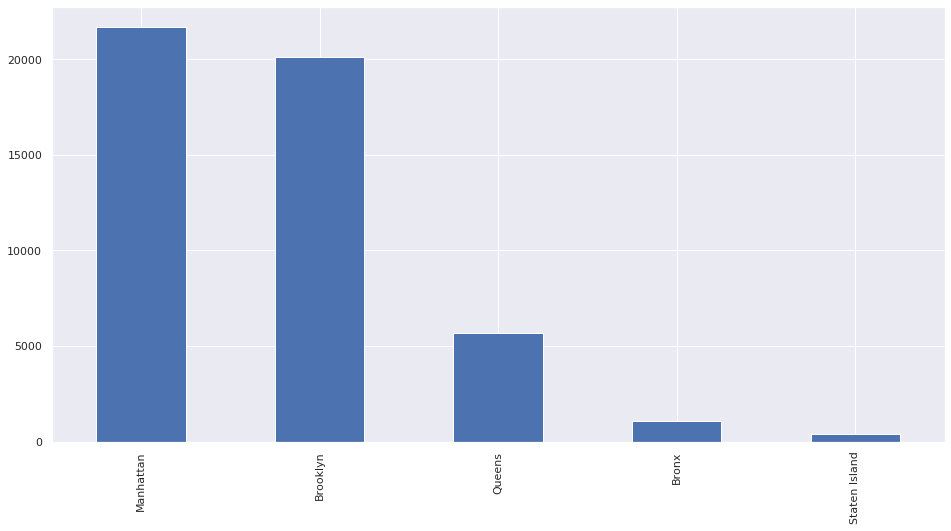

In [273]:
df.neighbourhood_group.value_counts().plot.bar();

- **Room type**

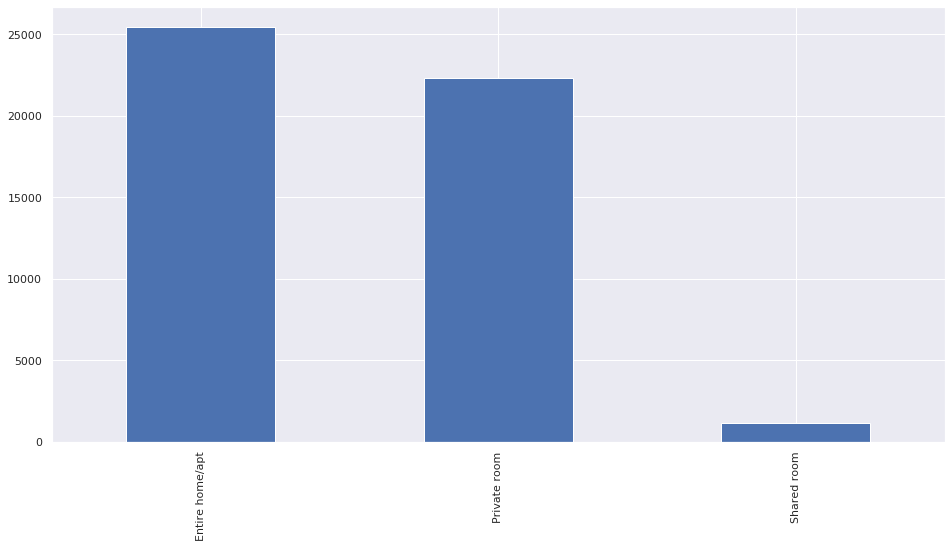

In [274]:
df.room_type.value_counts().plot.bar();

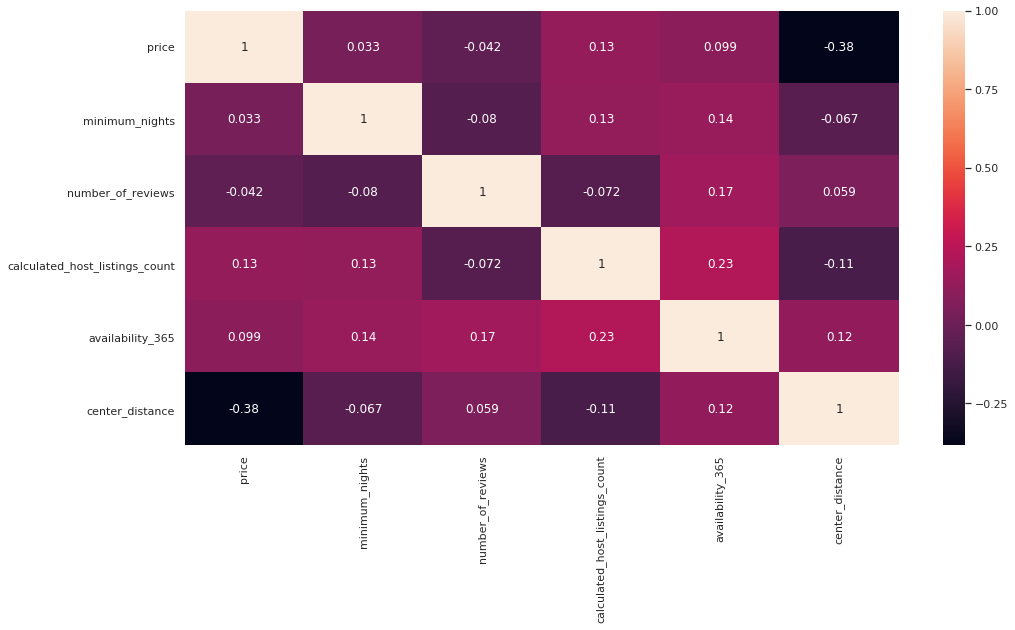

In [193]:
sns.heatmap(df.corr(), annot=True);

### Предобработка переменных

- **Закодируем категориальные переменные:**

In [313]:
room_type = pd.get_dummies(df.room_type, drop_first=True)
neighbourhood_group = pd.get_dummies(df.neighbourhood_group, drop_first=True)
# neighbourhood = pd.get_dummies(df.neighbourhood, drop_first=True)

In [314]:
df = df.drop(['room_type', 'neighbourhood_group', 'neighbourhood'], axis=1)

In [318]:
df = pd.concat([df, room_type, neighbourhood_group], axis=1)

In [319]:
df_train, df_test = train_test_split(df, test_size=0.3)

In [320]:
scaler = StandardScaler()
scaler.fit(df_train[
    ['minimum_nights',
     'number_of_reviews',
     'calculated_host_listings_count',
     'availability_365',
     'center_distance']
])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [321]:
df_train_scale = scaler.transform(
    df_train[['minimum_nights',
              'number_of_reviews',
              'calculated_host_listings_count',
              'availability_365',
              'center_distance']]
)

df_test_scale = scaler.transform(
    df_test[['minimum_nights',
             'number_of_reviews',
             'calculated_host_listings_count',
             'availability_365',
             'center_distance']]
)

In [285]:
df_train.loc[:,['minimum_nights',
              'number_of_reviews',
              'calculated_host_listings_count',
              'availability_365',
              'center_distance']] = df_train_scale

df_test.loc[:,['minimum_nights',
              'number_of_reviews',
              'calculated_host_listings_count',
              'availability_365',
              'center_distance']] = df_test_scale

In [322]:
print(df_train.shape)
print(df_test.shape)

(34218, 12)
(14666, 12)


In [323]:
X_train = df_train.drop('price', axis=1).values
X_test = df_test.drop('price', axis=1).values

y_train = df_train.price.values
y_test = df_test.price.values

### Константный прогноз

In [324]:
y_mean = np.mean(y_train)
y_pred_naive = np.ones(y_test.shape[0]) * y_mean
np.exp(y_mean)

112.65084953618418

In [347]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_test, y_pred_naive)

12.021712045588542

In [348]:
def print_metrics(y_test, y_pred):
    print(f'MAE: {metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred)):.2f}')
    print(f'RMSE: {np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred))):.2f}')
    print('R2:',  metrics.r2_score(np.exp(y_test), np.exp(y_pred)))
    print(f'MAPE: {mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred)):.2f}%')

In [349]:
print_metrics(y_test, y_pred_naive)

MAE: 86.52
RMSE: 251.15
R2: -0.029405947080776595
MAPE: 61.12%


### Линейная регрессия

In [352]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [353]:
y_predict = model.predict(X_test)

In [354]:
print_metrics(y_test, y_pred_naive)
print()
print_metrics(y_test, y_predict)

MAE: 86.52
RMSE: 251.15
R2: -0.029405947080776595
MAPE: 61.12%

MAE: 64.36
RMSE: 237.41
R2: 0.08020203136041992
MAPE: 36.18%


In [337]:
feautures_importance = pd.DataFrame({'feautures': df.drop('price', axis=1).columns, 'importance': model.coef_})
feautures_importance.set_index('feautures', inplace=True)
feautures_importance.sort_values('importance', ascending=False, inplace=True)
feautures_importance

,importance
feautures,
Manhattan,0.173351
availability_365,0.000802
calculated_host_listings_count,-0.000216
number_of_reviews,-0.000764
minimum_nights,-0.002455
Queens,-0.003234
Staten Island,-0.016279
Brooklyn,-0.082411
Private room,-0.749593


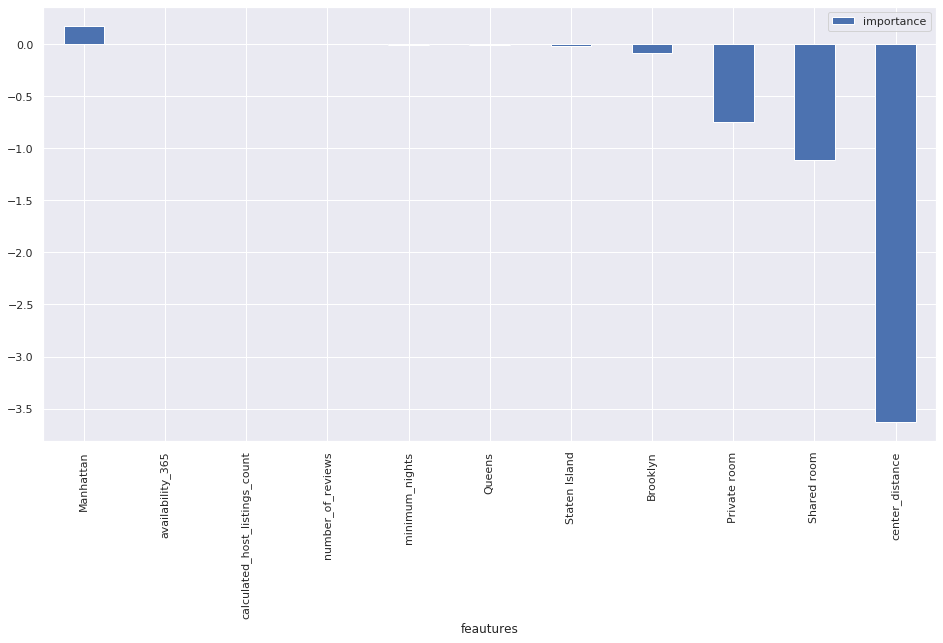

In [338]:
feautures_importance.plot.bar();

### Lasso регрессия

In [342]:
model_lasso = Lasso()

param_grid = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}

grid = GridSearchCV(model_lasso, param_grid, cv=5)
grid.fit(X_train, y_train)

print(f'Лучшее значение alpha: {grid.best_params_["alpha"]}')

Лучшее значение alpha: 0.0001


In [351]:
model = Lasso()
model.fit(X_train, y_train)

y_predict = model.predict(X_test)

print_metrics(y_test, y_pred_naive)
print()
print_metrics(y_test, y_predict)

MAE: 86.52
RMSE: 251.15
R2: -0.029405947080776595
MAPE: 61.12%

MAE: 85.48
RMSE: 250.39
R2: -0.023120222250840428
MAPE: 60.45%


In [343]:
feautures_importance = pd.DataFrame({'feautures': df.drop('price', axis=1).columns, 'importance': model.coef_})
feautures_importance.set_index('feautures', inplace=True)
feautures_importance.sort_values('importance', ascending=False, inplace=True)
feautures_importance

,importance
feautures,
calculated_host_listings_count,0.001573
availability_365,0.000370
minimum_nights,0.000000
center_distance,-0.000000
Private room,-0.000000
Shared room,-0.000000
Brooklyn,-0.000000
Manhattan,0.000000
Queens,-0.000000


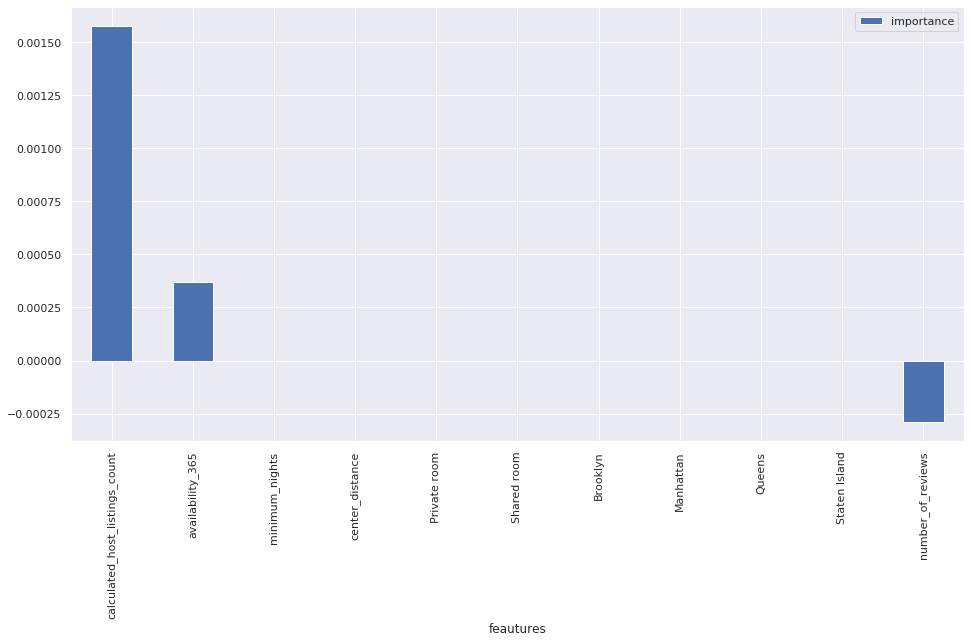

In [344]:
feautures_importance.plot.bar();

In [345]:
print_metrics(y_test, y_pred_naive)
print()
print_metrics(y_test, y_predict)

MAE: 86.52
RMSE: 251.15
MAPE: 61.12%

MAE: 85.48
RMSE: 250.39
MAPE: 60.45%
